# Towards SAT Solving for Graph Aggregation
This notebook is based on the notebook for the course on *Computational Social Choice*, demonstrating how to use SAT-solving technology to reason about voting rules, prepared by [Ulle Endriss](https://staff.science.uva.nl/u.endriss/), ILLC, University of Amsterdam (November 2023).

This notebook is part of the implementation of a project extending SAT solving to the graph aggregation domain, as set up by [Endriss & Grandi, 2018](https://dl.acm.org/doi/abs/10.1145/3184558.3186231).

## System Requirements
You need to be able to run [Jupyter Notebooks](https://realpython.com/jupyter-notebook-introduction/) for Python 3 and you need to have the [PySAT](https://pysathq.github.io/) toolkit [installed](https://pysathq.github.io/installation/) on your machine. 

## Using this Notebook
The recommended way of using this notebook is to first restart the kernel and then run the entire notebook cell by cell. With the exception of two cells near the end of the notebook, this should not generate any error messages. Then go to any of the cells labelled **"Try it!"** and see what happens when you make changes to those cells and run them again.

Beware that some of the code is only explained on the slides and not here. Note that I followed to a 'minimalist' coding philosophy: trying to write as little code as possible and trying to make that code as easy to understand as possible. So this is neither maximally efficient (but easily fast enough for our present needs) nor maximally robust (but it works fine when used as intended).

## Imports
We first import some extra functionality from standard Python modules, so we can easily (a) compute the factorial of a given number, (b) work with the list of all permutations of a given list, and (c) randomly shuffle a given list.

In [1]:
from math import factorial
from itertools import permutations
from random import shuffle

## SAT Solving
We want to use SAT-solving technology to reason about voting rules. In this section, we provide the methods required to make this technology available to us. Specifically, we define methods to check whether a given formula is satisfiable, to enumerate all models of a satisfiable formula, and to compute a minimally unsatisfiable subset (MUS) of an unsatisfiable set of clauses. Our methods are simple wrappers around more sophisticated versions of the same methods provided by PySAT. Note that none of this is specific to our intended application to social choice theory. 

A *SAT solver* is a program that can determine whether a given formula of propositional logic is *satisfiable*. Recall that a formula $\varphi$ is satisfiable if there exists an assignment of truth values to the propositional variables occurring in $\varphi$ for which $\varphi$ evaluates to *true*. Formulas must be provided in *conjunctive normal form* (CNF). Recall that a formula in CNF is a conjunction ('and') of *clauses*, with a clause being a disjunction ('or') of *literals*. A literal, in turn, is either a propositional variable or the negation of a propositional variable. 

In our code, we use positive integers to represent positive literals (i.e., propositional variables), negative integers to represent negative literals (i.e., negations of propositional variables), lists of integers to represent clauses, and lists of such lists to represent formulas in CNF. Thus, for example, the list `[[1,-3,2],[-2]]` represents the formula $(p_1 \lor \neg p_3 \lor p_2) \land (\neg p_2)$. This is known as the DIMACS format.

We first import the required functionality from PySAT. The first import makes available the solver Glucose 3.0 (any of the other solvers should work just as well). The second makes available a module for working with weighted formulas in CNF, which is required for the implementation of the MUS extractor provided by means of the third import.

In [2]:
from pysat.solvers import Glucose3
from pysat.formula import WCNF
from pysat.examples.musx import MUSX

The method `solve()` implemented below offers easy access to the corresponding method of our chosen SAT solver. If you apply this method to a formula $\varphi$ in CNF, it will return the string `UNSATISFIABLE` in case $\varphi$ is unsatisfiable, and otherwise a *model* that satisfies $\varphi$. Any such a model is presented in the form of a list of positive and negative integers, indicating which propositional variables must be set to *true* and which must be set to *false*.

In [3]:
def solve(cnf):
    solver = Glucose3()
    for clause in cnf: solver.add_clause(clause)
    if solver.solve():
        return solver.get_model()
    else:
        return('UNSATISFIABLE')

**Try it!** You can change the CNF formula (i.e., the list of lists of integers) in the example below to test different formulas for their satisfiability.

In [4]:
solve([[1,2], [1,-2], [-1,2], [-1,-2]])

'UNSATISFIABLE'

The method `enumModels()` can be used to enumerate all satisfying models of a given formula in CNF. Keep in mind that this is a demanding operation and that the number of models can be huge. Note that the object returned by `enumModels()` is an iterator (not a list). A simple way of inspecting it is to use the `list()` method on the object returned by `enumModels()`.

In [5]:
def enumModels(cnf):
    solver = Glucose3()
    for clause in cnf: solver.add_clause(clause)
    return solver.enum_models()

**Try it!**

In [6]:
models = enumModels([[-1,-2,3], [2], [-3,1]])
print(list(models))

[[-1, 2, -3], [1, 2, 3]]


The method `getMUS()` can be used to compute an MUS for a given formula in CNF (which should be unsatisfiable). Note that a given formula might have more than one MUS, and `getMUS()` does not necessarily return the smallest MUS (because computing a cardinality-minimal MUS is a much more demanding operation).

In [7]:
def getMUS(cnf):
    wcnf = WCNF()
    for clause in cnf: wcnf.append(clause, 1)
    mus = MUSX(wcnf,verbosity=0).compute()
    return list(cnf[i-1] for i in mus)

**Try it!** The list we obtain represents an unsatisfiable set of clauses that becomes satisfiable as soon as we remove even a single clause from it.

In [8]:
getMUS([[-1,2], [1], [-3,4], [-2], [3,-4]])

[[-1, 2], [1], [-2]]

## Preferences and Profiles
In this section, we set up everything we need to represent (a) voters, (b) alternatives, (c) preferences of a single voter over the alternatives, and (d) profiles bundling the preferences of all voters. Observe that $n$ voters and $m$ alternatives, there are $m!$ possible preferences and $m!^n$ possible profiles.

We first fix `n`, the number of voters, and `m`, the number of alternatives. For much of what we are going to do, we shall assume `n = 2` and `m = 3`. Keep in mind that the number of objects we are dealing with grows exponentially in `n` and superexponentially in `m`, so things are unlikely to work well (or at all) for even moderately larger numbers.

In [9]:
from config import config

In [10]:
# config, utils, axioms, properties, literals
from config import config
from utils import *
from axioms import *
from properties import *

In [11]:
graphCNF(get_graph(1, config.v))

[(1,), (-2,), (-3,), (-4,), (-5,), (-6,), (-7,), (-8,), (-9,)]

In [12]:
cnfCompleteness()

[(2, 4), (3, 7), (4, 2), (6, 8), (7, 3), (8, 6)]

In [17]:
def generate_graph_subsets(cnf_properties):
    acceptable_graphs = []
    for graph_int in allGraphs():
        edges = get_graph(graph_int, config.v)
        cnf = graphCNF(edges)
        for cnf_property in cnf_properties:
            cnf += cnf_property()
#         print(cnf)
        if solve(cnf) != 'UNSATISFIABLE':
            acceptable_graphs.append(graph_int)
            
    return acceptable_graphs

In [42]:
graphs = generate_graph_subsets([cnfIrreflexivity, cnfTransitivity, cnfCompleteness])
# graphs = generate_graph_subsets([cnfIrreflexivity, cnfConnectedness, cnfTransitivity, cnfCompleteness])
graphs

[38, 44, 104, 134, 194, 200]

[(0, 1), (0, 2), (1, 2)]


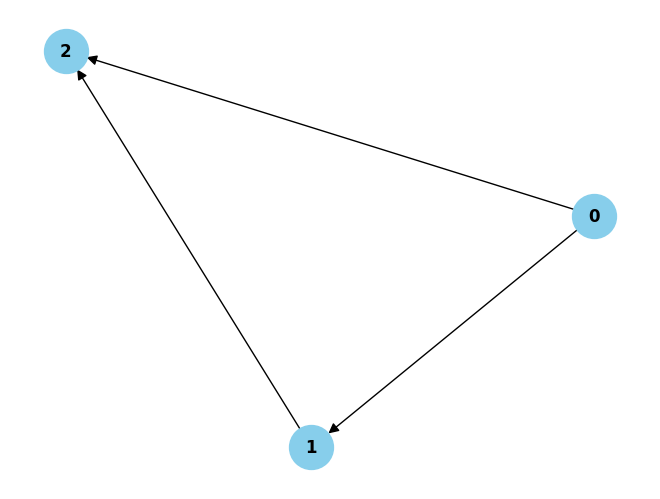

[(0, 2), (1, 0), (1, 2)]


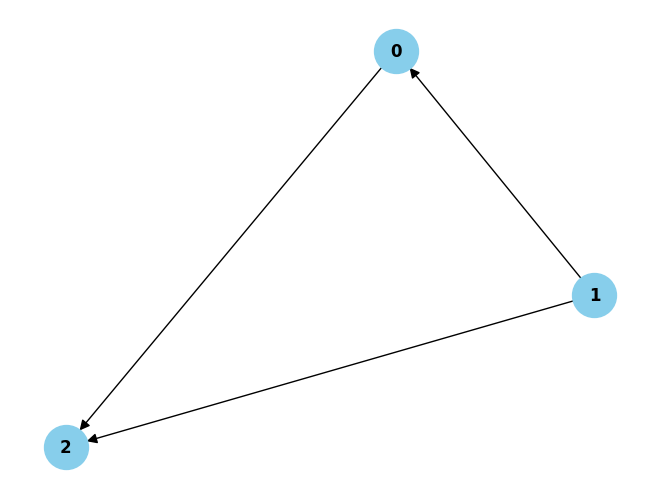

[(1, 0), (1, 2), (2, 0)]


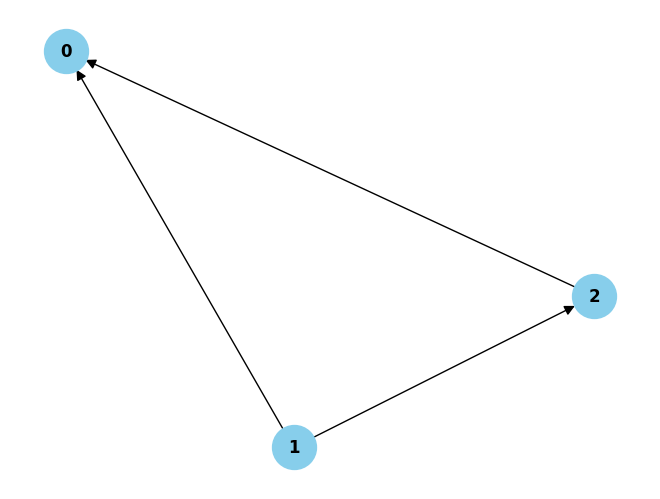

[(0, 1), (0, 2), (2, 1)]


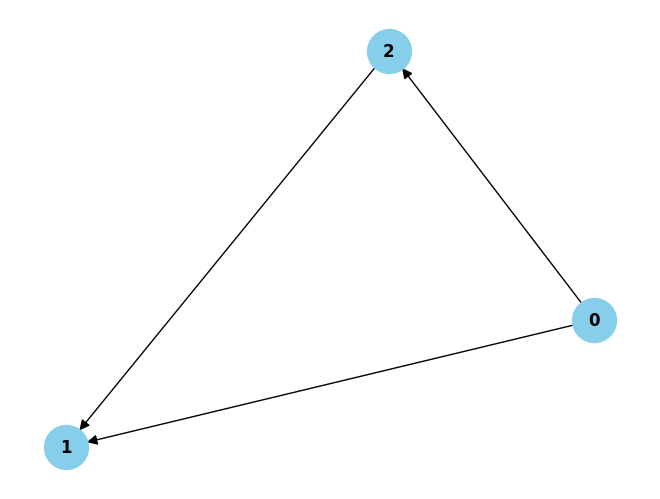

[(0, 1), (2, 0), (2, 1)]


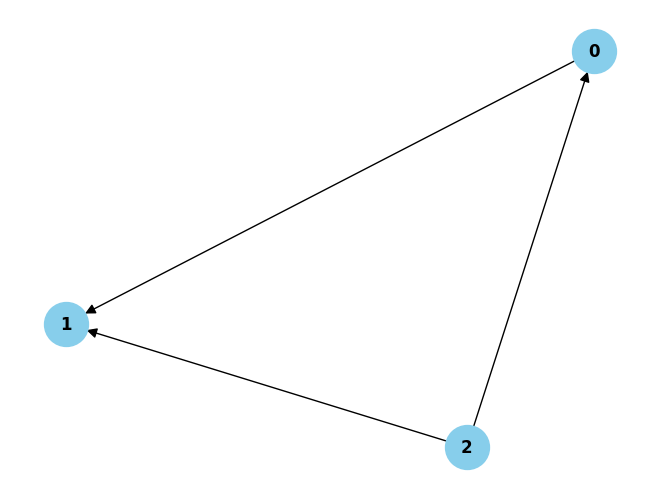

[(1, 0), (2, 0), (2, 1)]


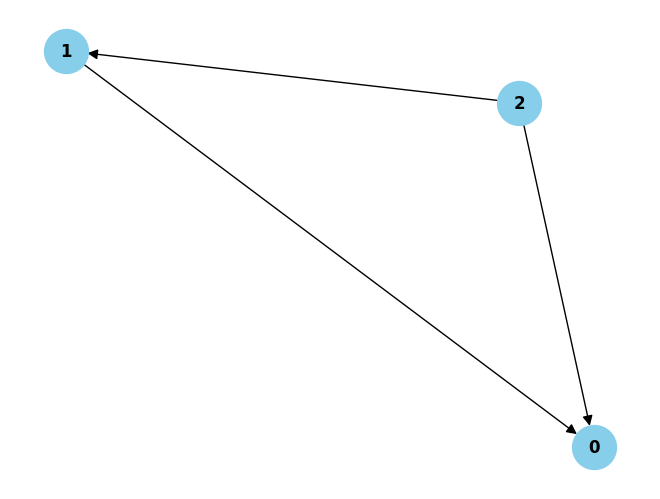

In [43]:
from plot import draw_labeled_graph
for graph in graphs:
    edges = get_graph(graph, config.v)
    print(edges)
    draw_labeled_graph(edges, config.v, "")

In [31]:
arrow_axioms = [iie, nondictatorship, unanimity, grounded]
cnf = []
for axiom in arrow_axioms:
    print(f"generating CNF for axiom {axiom}")
    new_cnfs = axiom(graphs)
    print(len(new_cnfs))
    
print(len(cnf))

generating CNF for axiom <function nondictatorship at 0x0000019AF2F65120>
4320
generating CNF for axiom <function unanimity at 0x0000019AF2F653F0>


KeyboardInterrupt: 

It will be convenient to also represent preferences and profiles as integers (just think of some enumeration of all preferences and assign integers to them, starting with `0`, and similarly for profiles). The method below can be used to return the set of all such integers representing profiles (we happen to not require a corresponding method for preferences).

**Try it!**

The next three methods allow us to retrieve lists of voters, alternatives, and profiles, respectively, that meet a certain condition. Such a condition can be any function mapping objects of the appropriate types to a boolean value.

In [14]:
def voters(condition):
    return [i for i in allVoters() if condition(i)]

In [15]:
def alternatives(condition):
    return [x for x in allAlternatives() if condition(x)]

In [16]:
def profiles(condition):
    return [r for r in allProfiles() if condition(r)]

**Try it!** For example, using [lambda expressions](https://realpython.com/python-lambda/) in Python to define suitable (boolean) conditions, we can retrieve the list of all alternatives that are different from alternative ``1``.

In [17]:
alternatives(lambda x : x!=1)

[0, 2]

Method `preference()` can be used to retrieve the number representing the preference order reported by a given voter `i` in a given profile `r`. The way I have chosen to implement this is to think of the numbers representing profiles as being written down in an `m!`-ary number system in which each digit represents the preference order of one voter (with voters being listed in inverse order, for technical convenience). For example, for `n=2` and `m=3`, profiles are 2-digit numbers with digits ranging from `0` to `5`. In this case, profile `50` (representing the number $5 \cdot 3!^1 + 0\cdot 3!^0 = 30$ in the decimal system) is the profile in which the second voter (corresponding to the first digit) has the last possible preference order (say, `2>1>0`) and the first voter (corresponding to the second digit) has the first possible preference order (say, `0>1>2`).

In [18]:
def preference(i, r):
    base = factorial(m)
    return ( r % (base ** (i+1)) ) // (base ** i)

Method `iVariants()` can be used to check whether profiles `r1` and `r2` are `i`-variants, i.e., to check whether in the two profiles all voters, except possibly voter `i`, report the same preferences.

In [19]:
def iVariants(i, r1, r2):
    return all(preference(j,r1) == preference(j,r2)
               for j in voters(lambda j : j!=i))

Method `preflist()` can be used to retrieve a list-representation of the preference order of a given voter `i` in a given profile `r`. This is implemented by generating the list of all permutations of the alternatives and then picking the $k$th element of that big list, where $k$ is obtained using `preference(i,r)`.

In [20]:
def preflist(i, r):
    preflists = list(permutations(allAlternatives()))
    return preflists[preference(i,r)]

We now have everything in place to implement the top-level methods we will actually need to reason about preferences and profiles. First among them is `prefers()`, which we can use to check whether voter `i` prefers alternative `x` to alternative `y` in profile `r`.

In [21]:
def prefers(i, x, y, r):
    mylist =  preflist(i, r) 
    return mylist.index(x) < mylist.index(y)

**Try it!** Let's check, for example, whether the second voter (`1`) prefers the first alternative (`0`) to the third alternative (`2`) in profile number `30`. 

In [22]:
prefers(1,0,2,30)

False

Method `top()` can be used to check whether voter `i` has alternative `x` at the top of her preference order in profile `r`.

In [23]:
def top(i, x, r):
    mylist =  preflist(i, r) 
    return mylist.index(x) == 0

**Try it!**

In [24]:
top(1,2,30)

True

The next two methods are simple *pretty-print* methods for preferences and profiles, respectively.

In [25]:
def strPref(i, r):
    return ''.join(str(x) for x in preflist(i,r))

In [26]:
def strProf(r):
    return '(' + ','.join(strPref(i,r) for i in allVoters()) + ')'

**Try it!**

In [27]:
strProf(30)

'(012,210)'

## Encoding Voting Rules

Method `posLiteral()` can be used to return the positive literal corresponding to the statement that in profile `r` it is the case that alternative `x` is a winner (but not necessarily the only one). Method `negLiteral()` returns the corresponding negative literal.

In [28]:
def posLiteral(r, x):
    return r * m + x + 1

In [29]:
posLiteral(1,2)

6

In [30]:
def negLiteral(r, x):
    return (-1) * posLiteral(r, x)

Method `strLiteral()` provide a simple *pretty-print* method for literals, and `strClause()` extends this to clauses (i.e., to lists of literals).

In [31]:
def strLiteral(lit):
    r = (abs(lit) - 1) // m
    x = (abs(lit) - 1) % m
    return ('not ' if lit<0 else '') + strProf(r) + '->' + str(x)

In [32]:
def strClause(clause):
    return ' or '.join(strLiteral(lit) for lit in clause)

Method `cnfAtLeastOne()` returns the CNF encoding the statement that a voting rule must always return at least one winner.

In [33]:
def cnfAtLeastOne():
    cnf = []
    for r in allProfiles():
        cnf.append([posLiteral(r,x) for x in allAlternatives()])
    return cnf    

Method `cnfResolute()` returns the CNF encoding the requirement that our voting rule must be resolute.

In [34]:
def cnfResolute():
    cnf = []
    for r in allProfiles():
        for x in allAlternatives():
            for y in alternatives(lambda y : x < y):
                cnf.append([negLiteral(r,x), negLiteral(r,y)])
    return cnf            

## Axioms
The following axioms encode various axioms we might want our voting rule to satisfy. Refer to the slide deck for explanation.

In [35]:
def cnfStrategyProof():
    cnf = []
    for i in allVoters():
        for r1 in allProfiles():
            for r2 in profiles(lambda r2 : iVariants(i,r1,r2)):
                for x in allAlternatives():
                    for y in alternatives(lambda y : prefers(i,x,y,r1)):
                        cnf.append([negLiteral(r1,y), negLiteral(r2,x)])
    return cnf                    

In [36]:
def cnfSurjective():
    cnf = []
    for x in allAlternatives():
        cnf.append([posLiteral(r,x) for r in allProfiles()])
    return cnf    

In [37]:
def cnfNonDictatorial():
    cnf = []
    for i in allVoters():
        clause = []
        for r in allProfiles():
            for x in alternatives(lambda x : top(i,x,r)):
                clause.append(negLiteral(r,x))
        cnf.append(clause)
    return cnf    

In [38]:
def most(bools):
    return sum(bools) > len(list(bools)) / 2

def cnfMajoritarian():
    cnf = []
    for x in allAlternatives():
        for r in profiles(lambda r : most(list(top(i,x,r) for i in allVoters()))):
            cnf.append([posLiteral(r,x)])
    return cnf

The dictionary `axiom` associates names of axioms (i.e., strings) with methods generating the formulas encoding those axioms. This will be useful later on when we want to determine which axiom was responsible for a given clause to have been generated. (For convenience and by a slight abuse of terminology, we are including the requirements of always returning at least one winner and to be resolute in our list of axioms here.) 

In [39]:
axiom = {
    'AtLeastOne' : cnfAtLeastOne(),
    'Resolute' : cnfResolute(),
    'StrategyProof' : cnfStrategyProof(),
    'Surjective' : cnfSurjective(),
    'NonDictatorial' : cnfNonDictatorial(),
    'Majoritarian' : cnfMajoritarian()
}

## Explaining Formulas
For a given clause or CNF, respectively, the next two methods allow us to display a simple explanation for how this formula has been generated. 

In [40]:
def explainClause(clause):
    reason = next((k for k in axiom if clause in axiom[k]), 'None')
    print(reason + ': ' + strClause(clause))

In [41]:
def explainCNF(cnf):
    for clause in cnf: explainClause(clause)

**Try it!** 

In [42]:
explainClause([-10,-17])

StrategyProof: not (120,012)->0 or not (210,012)->1


## HW4

In [43]:
def profile_preflist(r):
    # gets preflists for all players for profile (index) r
    profile = []
    for i in allVoters():
        prefs = preflist(i,r)
        profile.append(prefs)
        
    return profile

def align_profiles(r1_int,r2_int):
    r1 = profile_preflist(r1_int)
    r2 = profile_preflist(r2_int)
    # check if swapping indices will yield the same profile (for checking neutrality)
    perms = list(permutations(allAlternatives()))
    perms.remove(tuple(allAlternatives()))
    #print(perms)
    for pe in perms:
        # try every "rename" permutation to test equivalence between two profiles
        r2_rename = []
        for pl in r2:
            # redo each ballot
            plist = []
            for x in pl:
                #swap alternative with the "equivalent" in the permutation
                plist.append(pe[x])
                
            r2_rename.append(tuple(plist))
        
        if r1 == r2_rename:
            return True, pe
                
    return False, False

In [44]:
def cnfAnonymous():
    # ANONYMITY: if two profiles have the same preference rankings just from different voters, then the winner must remain the same
    # VIOLATION: two profiles have the exact same preferences, but the winner changes
    cnf = []
    # cycle through all profiles
    for r1 in allProfiles():
        r1_perms = list(permutations(profile_preflist(r1)))
        for r2 in allProfiles():
            if tuple(profile_preflist(r2)) in r1_perms:
                for x in allAlternatives():
                    # if x wins r1, x must also win r2
                    cnf.append([negLiteral(r1,x), posLiteral(r2,x)])
    return cnf

def cnfNeutral():
    # NEUTRALITY: if two profiles have the same preference rankings, but simply with swapped names per alternative, then the winner changes in a corresponding manner
    cnf = []
    for r1 in allProfiles():
        for r2 in allProfiles():
            cond, pe = align_profiles(r1,r2)
            if cond:
                # if these are the same when alternatives are permutated 
                for x in allAlternatives():
                    # if some pe[x] is winner in r1 then the corresponding x must be the winner in r2
                    cnf.append([negLiteral(r1,pe[x]), posLiteral(r2, x)])
    return cnf

In [45]:
axiom = {
    'AtLeastOne' : cnfAtLeastOne(),
    'Resolute' : cnfResolute(),
    'StrategyProof' : cnfStrategyProof(),
    'Surjective' : cnfSurjective(),
    'NonDictatorial' : cnfNonDictatorial(),
    'Majoritarian' : cnfMajoritarian(),
    'Neutral' : cnfNeutral(),
    'Anonymous' : cnfAnonymous()
}

def update_axiom():
    """ Reset axiom list to help MUS descriptions """
    axiom = {
        'AtLeastOne' : cnfAtLeastOne(),
        'Resolute' : cnfResolute(),
        'StrategyProof' : cnfStrategyProof(),
        'Surjective' : cnfSurjective(),
        'NonDictatorial' : cnfNonDictatorial(),
        'Majoritarian' : cnfMajoritarian(),
        'Anonymous' : cnfAnonymous(),
        'Neutral' : cnfNeutral(),
        
    }
    return axiom

### Case n,m=2,2

In [46]:
def wrap_cnf():
    """ Helper function to run code to solve CNF and extract MUS """
    print(len(cnfAnonymous()), len(cnfNeutral()))
    cnf = cnfAnonymous() + cnfNeutral() + cnfResolute() + cnfAtLeastOne()
    print(solve(cnf))
    print("Number of satisfying models:", len(list(enumModels(cnf))))
    if len(list(enumModels(cnf))) == 0:
        print()
        print(getMUS(cnf))
        print(explainCNF(getMUS(cnf)))

In [47]:
n,m=2,2
axiom = update_axiom()
wrap_cnf()


12 8
UNSATISFIABLE
Number of satisfying models: 0

[[-4, 6], [-6, 4], [-4, 5], [-3, 6], [-5, -6], [3, 4]]
Anonymous: not (10,01)->1 or (01,10)->1
Anonymous: not (01,10)->1 or (10,01)->1
Neutral: not (10,01)->1 or (01,10)->0
Neutral: not (10,01)->0 or (01,10)->1
Resolute: not (01,10)->0 or not (01,10)->1
AtLeastOne: (10,01)->0 or (10,01)->1
None


### Case n,m=2,3

In [48]:
n,m=2,3
axiom = update_axiom()
wrap_cnf()

198 540
[-1, -2, 3, 4, -5, -6, -7, -8, 9, -10, -11, 12, -13, 14, -15, -16, 17, -18, 19, -20, -21, -22, 23, -24, -25, -26, 27, -28, -29, 30, -31, 32, -33, -34, 35, -36, -37, -38, 39, -40, -41, 42, -43, -44, 45, -46, 47, -48, 49, -50, -51, 52, -53, -54, -55, -56, 57, -58, -59, 60, -61, 62, -63, 64, -65, -66, 67, -68, -69, 70, -71, -72, -73, 74, -75, -76, 77, -78, 79, -80, -81, 82, -83, -84, -85, 86, -87, -88, -89, 90, -91, 92, -93, -94, 95, -96, 97, -98, -99, 100, -101, -102, -103, -104, 105, 106, -107, -108]
Number of satisfying models: 9


### Case n,m=3,2

In [49]:
n,m=3,2
axiom = update_axiom()
wrap_cnf()

40 16
[-1, 2, -3, 4, -5, 6, 7, -8, -9, 10, 11, -12, 13, -14, 15, -16]
Number of satisfying models: 4


### Case n,m=3,3

In [50]:
n,m=3,3
axiom = update_axiom()
wrap_cnf()

2988 3240
UNSATISFIABLE
Number of satisfying models: 0

[[-207, 582], [-252, 582], [-582, 207], [-68, 207], [-69, 252], [-67, 582], [-207, 581], [-581, -582], [67, 68, 69]]
Anonymous: not (102,210,021)->2 or (021,102,210)->2
Anonymous: not (210,021,102)->2 or (021,102,210)->2
Anonymous: not (021,102,210)->2 or (102,210,021)->2
Neutral: not (201,120,012)->1 or (102,210,021)->2
Neutral: not (201,120,012)->2 or (210,021,102)->2
Neutral: not (201,120,012)->0 or (021,102,210)->2
Neutral: not (102,210,021)->2 or (021,102,210)->1
Resolute: not (021,102,210)->1 or not (021,102,210)->2
AtLeastOne: (201,120,012)->0 or (201,120,012)->1 or (201,120,012)->2
None
